# ADS - Network analysis module, homework 1

In [47]:
#add necessary libraries
import pycombo # combo community detection package
import networkx as nx #library supporting networks
from networkx.algorithms import community
import matplotlib.pyplot as plt #plotting
import pandas as pd
import numpy as np
import scipy.stats as stat
import numpy as np
#make sure plots are embedded into the notebook
%pylab inline 
import statsmodels.api as sm
import warnings
import geopandas as gpd
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


## Task 1. Analysis of Les Miserables network 

In [48]:
#uploading the classical coappearance network of characters in the novel "Les Miserables" to analyze
#first download the data from https://raw.githubusercontent.com/CUSP2021ADS/Data/main/ClassicNet/lesmis.gml
G = nx.read_gml('lesmis.gml') 

### Q1. Visualize the network below with node labes and sizes proportional to node degree

In [49]:
np.array(list(dict(G.degree()).values()))

array([10,  1,  3,  3,  1,  1,  1,  1,  1,  1,  1, 36,  2,  1,  1,  1,  9,
        7,  7,  7,  7,  7,  7, 15, 11, 16, 11, 17,  4,  8,  2,  4,  1,  2,
        6,  6,  6,  6,  6,  3,  1, 11,  3,  3,  2,  1,  1,  2, 22,  7,  2,
        7,  2,  1,  4, 19,  2, 11, 15, 11,  9, 11, 13, 12, 13, 12, 10,  1,
       10, 10, 10,  9,  3,  2,  2,  7,  7])

254

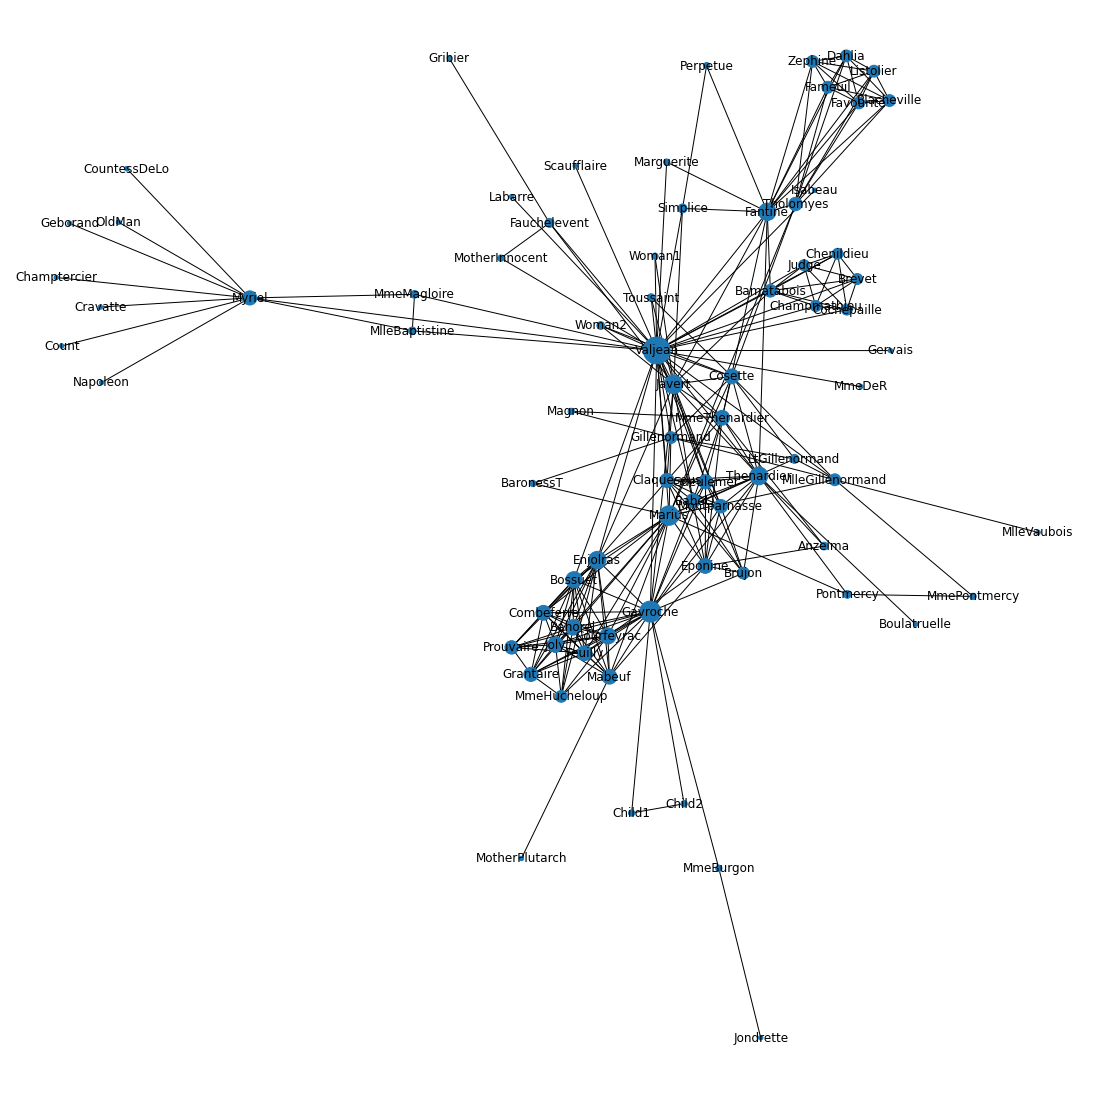

In [50]:
random.seed(2015)
plt.figure(figsize = (15,15))
nx.draw(G,node_size=20*np.array(list(dict(G.degree()).values())),with_labels=True)
G.size()

### Q2. Report top nodes by centrality
Print the node labels and corresponding centrality measure for top 5 nodes in terms of

a) degree centrality;

b) betweenness centrality;

c) closeness centrality;

In [51]:
#output top tn centrality scores, given the dictionary d
def topdict(d,tn):
    ind=sorted(dict(d), key=dict(d).get, reverse=True)
    for i in range(0,tn):
        print('{0}|{1}:{2}'.format(i+1,ind[i],d[ind[i]]))

In [52]:
#compute centrality measures
deg_centr = nx.degree(G)
betw_centr = nx.betweenness_centrality(G)

In [53]:
topdict(deg_centr,5)

1|Valjean:36
2|Gavroche:22
3|Marius:19
4|Javert:17
5|Thenardier:16


In [54]:
topdict(betw_centr,5)

1|Valjean:0.5699890527836184
2|Myriel:0.17684210526315788
3|Gavroche:0.16511250242584766
4|Marius:0.132032488621946
5|Fantine:0.12964454098819422


In [55]:
closeness_centr = nx.closeness_centrality(G)
topdict(closeness_centr,5)

1|Valjean:0.6440677966101694
2|Marius:0.5314685314685315
3|Thenardier:0.5170068027210885
4|Javert:0.5170068027210885
5|Gavroche:0.5135135135135135


### Q3. Analyze stability of Pagerank centrality
Analyze the impact of parameter $\alpha$ in pagerank centrality for the given network: compare top 5 nodes for different values of $\alpha=0.95, 0.9, 0.85, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1$ and point out an interval for which the ranking remains mostly stable.

In [56]:
alpha=[0.95, 0.9, 0.85, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]

In [57]:
for a in alpha:
    pr_centr = nx.pagerank(G,a)
    print('Teleport parameter={0}'.format(a))
    topdict(pr_centr,5)

Teleport parameter=0.95
1|Valjean:0.0747043161907721
2|Gavroche:0.03955288718377238
3|Marius:0.03430243839798216
4|Myriel:0.0334606288129395
5|Javert:0.0323959317526778
Teleport parameter=0.9
1|Valjean:0.07570137903943519
2|Myriel:0.039655318611340286
3|Gavroche:0.03739018829226064
4|Marius:0.03238365765284897
5|Javert:0.03134631873222991
Teleport parameter=0.85
1|Valjean:0.07543374445332472
2|Myriel:0.042803439760757324
3|Gavroche:0.035764123431619346
4|Marius:0.03089270192040647
5|Javert:0.030302597127170365
Teleport parameter=0.8
1|Valjean:0.07442184631334865
2|Myriel:0.04434110258590558
3|Gavroche:0.03435748592585355
4|Marius:0.029597643233466888
5|Javert:0.02926406217500744
Teleport parameter=0.7
1|Valjean:0.0709527717328387
2|Myriel:0.0448978476113381
3|Gavroche:0.03176794006501972
4|Marius:0.027267015891693083
5|Javert:0.02720525409804276
Teleport parameter=0.6
1|Valjean:0.06608136478461614
2|Myriel:0.04355003256779984
3|Gavroche:0.02923250385990771
4|Javert:0.025172680359553327

So for the values of damping parameter between 0.4 and 0.95 top five nodes are the same, just the order is varied slightly (exactly the same between 0.7 and 0.85). For the values $\alpha=0.1-0.3$ node  Marius is replaced with the node Thenardier in the top 5 list

### Q4. Partition the network using any available algorithm of your choice (e.g. Combo), report network partition modularity score and visualize the partition (different communities with different colors)

In [58]:
#visualize network partitioning given node locations pos
def visualizePartition(G,partition,pos):
    N=len(G.nodes())
    s=4+4*int(log10(N))
    plt.figure(figsize=(s,s))
    PN=max(partition.values())
    my_cmap = matplotlib.cm.hsv(np.linspace(0,1,PN+1)) #create a colormap for a given number of communities
    c=[]
    for n in G.nodes():
        c.append(1.0*partition[n]/PN)
    nx.draw(G,pos=pos,with_labels=False,arrows=True,node_size=300,node_color=c,width=1,edge_color='black')

In [59]:
def make_weighted(G):
    WG=G
    for e in WG.edges():
        WG[e[0]][e[1]]['weight']=1
    return WG    

In [60]:
#partition Les Miserables network using Combo method
G = make_weighted(G)
PClesmis=pycombo.execute(G,Inf)[0]
print('Les Miserables Combo partitioning modularity={0}'.format(pycombo.execute(G,Inf)[1]))

Les Miserables Combo partitioning modularity=0.560008370016743


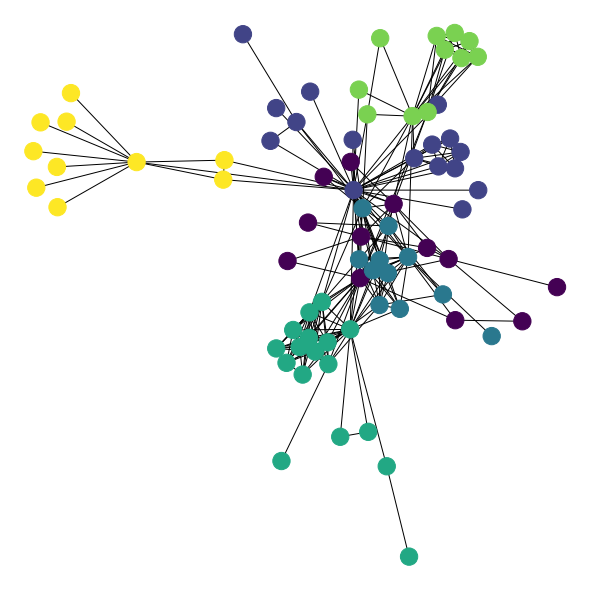

In [61]:
random.seed(2015)
visualizePartition(G,PClesmis,None)

In [62]:
def sets2dictPartition(spart):
    part={}
    c=1
    for cset in spart:
        cpart={n:c for n in cset}
        part.update(cpart)
        c+=1
    return part    
def modularity(G,partition):
    #compute network modularity according to the given partitioning
    nodes=list(G.nodes())
    #compute node weights and total network weight
    if G.is_directed():
        w1=G.out_degree(weight='weight')
        w2=G.in_degree(weight='weight')
        T=1.0*sum([e[2]['weight'] for e in G.edges(data=True)])
    else:
        w1=G.degree(weight='weight')
        w2=G.degree(weight='weight')
        T=1.0*sum([(1+(e[0]!=e[1]))*e[2]['weight'] for e in G.edges(data=True)])
    M=0 #start accumulating modularity score
    for a in nodes:
        for b in nodes:
            #if (G.is_directed())|(b>=a):
                if partition[a]==partition[b]: #if nodes belong to the same community
                    #get edge weight
                    if G.has_edge(a,b):
                        e=G[a][b]['weight']
                    else:
                        e=0
                    M+=e/T-w1[a]*w2[b]/(T**2) #add modularity score for the considered edge 
    return M                

In [63]:
#partition Les Miserables network using greedy heuristic
PLlesmis=sets2dictPartition(community.greedy_modularity_communities(G))
print('Les Miserables greedy partitioning modularity={0}'.format(modularity(G,PLlesmis)))

Les Miserables greedy partitioning modularity=0.500596751193504


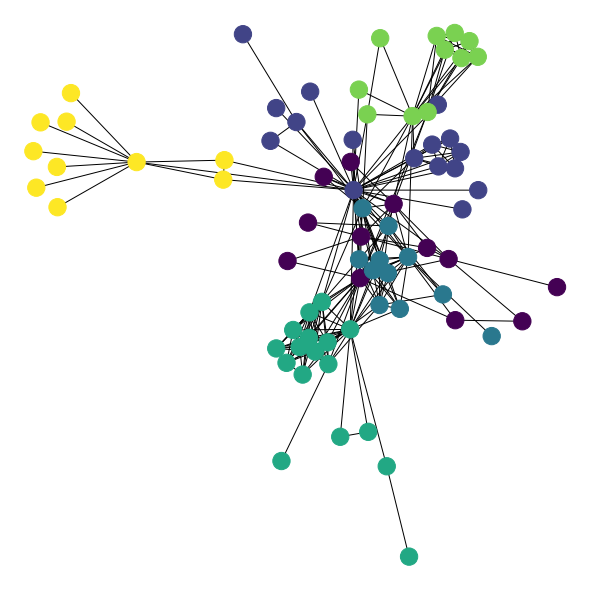

In [64]:
random.seed(2015)
visualizePartition(G,PClesmis,None)

## Task 2 (World airports). 
### Q1. 
Find connected components, report their number and the sizes.  

### Q2. 
In the largest connected component find and report (print a list of city names and centrality scores) top 10 airports by each centrality metric (degree, betweenneass, closeness, pagerank with $alpha=0.85$). 

### Q3. 
Find maximum and average network distance of the shortest path (number of edges, regardless of size) between all pairs of the airports from the largest connected component. Visualize the shortest path of the maximum length.

### Q4. 
Find average network distance among the top 100 airports by pagerank (with $alpha=0.85$)

### Q5.
Partition the network using Combo algorithm, visualize the partition 


In [65]:
cities = pd.read_csv('https://raw.githubusercontent.com/CUSP2021ADS/Data/main/airportData/citiesTable.csv', index_col=0 )
cities.head()

,country name,most active airport,long. most active airport,lat. most active airport,number of routes,number incoming flights,number outcoming flights,number incoming domestic flights,number outcoming domestic flights,number incoming international flights,number outcoming international flights,only domestic flights,average distance,max. distance
city name,,,,,,,,,,,,,,
London,United Kingdom,Heathrow,-0.103,51.795,1984,993,992,57,57,936,934,0,3228,11153
Chicago,United States,Chicago Ohare Intl,-87.842,42.631,1406,705,702,526,523,179,178,0,2328,12416
Paris,France,Charles De Gaulle,2.916,49.021,1254,626,629,68,68,558,560,0,3367,11652
Moscow,Russia,Domododevo,38.510,55.681,1179,589,591,231,231,358,359,0,2772,10054
Shanghai,China,Pudong,122.342,31.238,1115,560,556,357,353,203,202,0,2235,12245


In [66]:
#create a network with city names as nodes
Flights=nx.Graph()
Flights.add_nodes_from(cities.index)

In [67]:
#now read the links
links = pd.read_csv('https://raw.githubusercontent.com/CUSP2021ADS/Data/main/airportData/citiesToCities.csv' , index_col=None )
links.head()

,departure city,long. departure (decimal),lat. departure (decimal),departure country,arrival city,long. departure (decimal).1,lat. departure (decimal).1,arrival country,number of routes,distance
0,Sao Paulo,-46.116,-23.054,Brazil,Rio De Janeiro,-42.740,-22.682,Brazil,18,348
1,Rio De Janeiro,-42.740,-22.682,Brazil,Sao Paulo,-46.116,-23.054,Brazil,18,348
2,Beijing,116.974,40.133,China,Shanghai,122.342,31.238,China,18,1100
3,Johannesburg,28.410,-25.566,South Africa,Cape Town,19.002,-33.942,South Africa,16,1299
4,Honolulu,-157.871,21.531,United States,Tokyo,140.643,36.274,Japan,16,6103


In [68]:
#create list of edges as tuples
EN=len(links.index)
edgelist=[(links['departure city'][j],links['arrival city'][j]) for j in range(EN)]

In [69]:
#add edges to the network
Flights.add_edges_from(edgelist)

a) Find connected components, report their number and the sizes.  

In [70]:
#find connected components, sorted by size
CC=sorted(nx.connected_components(Flights), key=len, reverse=True)

In [71]:
#report their number
len(CC)

4

In [72]:
#report their size
[len(cc) for cc in CC]

[2981, 3, 2, 2]

In [73]:
FlightsLC=Flights.subgraph(CC[0]) #get largest connected component

b) In the largest connected component find and report (print a list of city names and centrality scores) top 10 airports by each centrality metric (degree, betweenneass, closeness, pagerank with $alpha=0.85$). 

In [74]:
#compute centrality measures
FL_deg_centr = nx.degree(FlightsLC)
FL_betw_centr = nx.betweenness_centrality(FlightsLC)
FL_close_centr = nx.closeness_centrality(FlightsLC)

In [75]:
FL_pagerank_centr = nx.pagerank(FlightsLC,0.85)

In [76]:
topdict(FL_deg_centr,10)

1|London:311
2|Paris:267
3|Frankfurt:232
4|Moscow:229
5|Amsterdam:208
6|Atlanta:208
7|Chicago:199
8|Beijing:184
9|Istanbul:181
10|Dallas-fort Worth:181


In [77]:
topdict(FL_betw_centr,10)

1|London:0.09076727836638496
2|Anchorage:0.08216371312591912
3|Paris:0.07784192121669775
4|Moscow:0.061038019702898835
5|Chicago:0.05813492835186721
6|Frankfurt:0.05452341641775677
7|Seattle:0.052719585605351275
8|Dubai:0.04644272199874113
9|Tokyo:0.0458546447882062
10|Toronto:0.04531466582661801


In [78]:
topdict(FL_close_centr,10)

1|London:0.42335559028271064
2|Frankfurt:0.4174838890445503
3|Paris:0.41637557635880956
4|Amsterdam:0.4094531464688101
5|New York:0.40053763440860213
6|Toronto:0.39632929910892406
7|Los Angeles:0.39601328903654487
8|Chicago:0.3927253558249868
9|Dubai:0.3926218708827404
10|Newark:0.38964435146443516


In [79]:
topdict(FL_pagerank_centr,10)

1|London:0.006659290961342694
2|Moscow:0.006409790102955394
3|Paris:0.006295939941422261
4|Atlanta:0.005016918307551103
5|Frankfurt:0.0048027793856764015
6|Chicago:0.004709824954255139
7|Dallas-fort Worth:0.0046932158818892835
8|Denver:0.00462642209344578
9|Houston:0.004398380214052283
10|Amsterdam:0.004312131801712511


c) Find maximum and average network distance of the shortest path (number of edges, regardless of size) between all pairs of the airports from the largest connected component. Visualize the shortest path of the maximum length.

In [80]:
#lengths of all the shortest paths
allpaths=dict(nx.shortest_path_length(FlightsLC))

In [81]:
#converted to a list
lengths=[j[1] for i in allpaths.items() for j in i[1].items()]

In [82]:
allpaths[list(allpaths.keys())[0]]

{'London': 0,
 'Antalya': 1,
 'Gothenborg': 1,
 'Plovdiv': 1,
 'Inverness': 1,
 'Dublin': 1,
 'La Rochelle': 1,
 'Goa': 1,
 'Havana': 1,
 'Szczechin': 1,
 'Lisbon': 1,
 'Accra': 1,
 'Hewandorra': 1,
 'Damascus': 1,
 'Johannesburg': 1,
 'Graz': 1,
 'Shanghai': 1,
 'Miami': 1,
 'Marseille': 1,
 'Frankfurt': 1,
 'Ashkhabad': 1,
 'New York': 1,
 'Antwerp': 1,
 'Nice': 1,
 'Sandefjord': 1,
 'Bratislava': 1,
 'Zurich': 1,
 'Guernsey': 1,
 'Halifax': 1,
 'Atlanta': 1,
 'Manchester': 1,
 'Cape Town': 1,
 'Seattle': 1,
 'Tokyo': 1,
 'Katowice': 1,
 'Malmoe': 1,
 'Nairobi': 1,
 'Milano': 1,
 'Genoa': 1,
 'Porto': 1,
 'Catania': 1,
 'Malaga': 1,
 'Venice': 1,
 'Zaragoza': 1,
 'Dortmund': 1,
 'Billund': 1,
 'Brive': 1,
 'Rzeszow': 1,
 'Santander': 1,
 'Bilbao': 1,
 'Rygge': 1,
 'Bari': 1,
 'Scarborough': 1,
 'Valladolid': 1,
 'Villafranca': 1,
 'Singapore': 1,
 'Luxor': 1,
 'Riga': 1,
 'Aarhus': 1,
 'Treviso': 1,
 'Gdansk': 1,
 'Ljubliana': 1,
 'Casablanca': 1,
 'Pisa': 1,
 'Hurghada': 1,
 'Abuja'

In [83]:
#diameter
max(lengths)

12

In [84]:
#average
mean(lengths)

3.938521291223708

In [85]:
argmax(lengths)//len(FlightsLC.nodes)

2426

In [86]:
allpath = allpaths[list(FlightsLC.nodes)[2426]]
# target
max(allpath, key=allpath.get)

'Red Devil'

In [87]:
# source
list(FlightsLC.nodes)[2426]

'Peawanuck'

In [88]:
longestpath = nx.algorithms.bidirectional_shortest_path(FlightsLC,'Peawanuck','Red Devil')
longestpath

['Peawanuck',
 'Attawapiskat',
 'Kashechewan',
 'Fort Albany',
 'Moosonee',
 'Timmins',
 'Toronto',
 'Seattle',
 'Anchorage',
 'Aniak',
 'Stony River',
 'Sleetmute',
 'Red Devil']

In [89]:
CityPos={c:(cities['long. most active airport'][c],cities['lat. most active airport'][c])
         for c in cities.index}

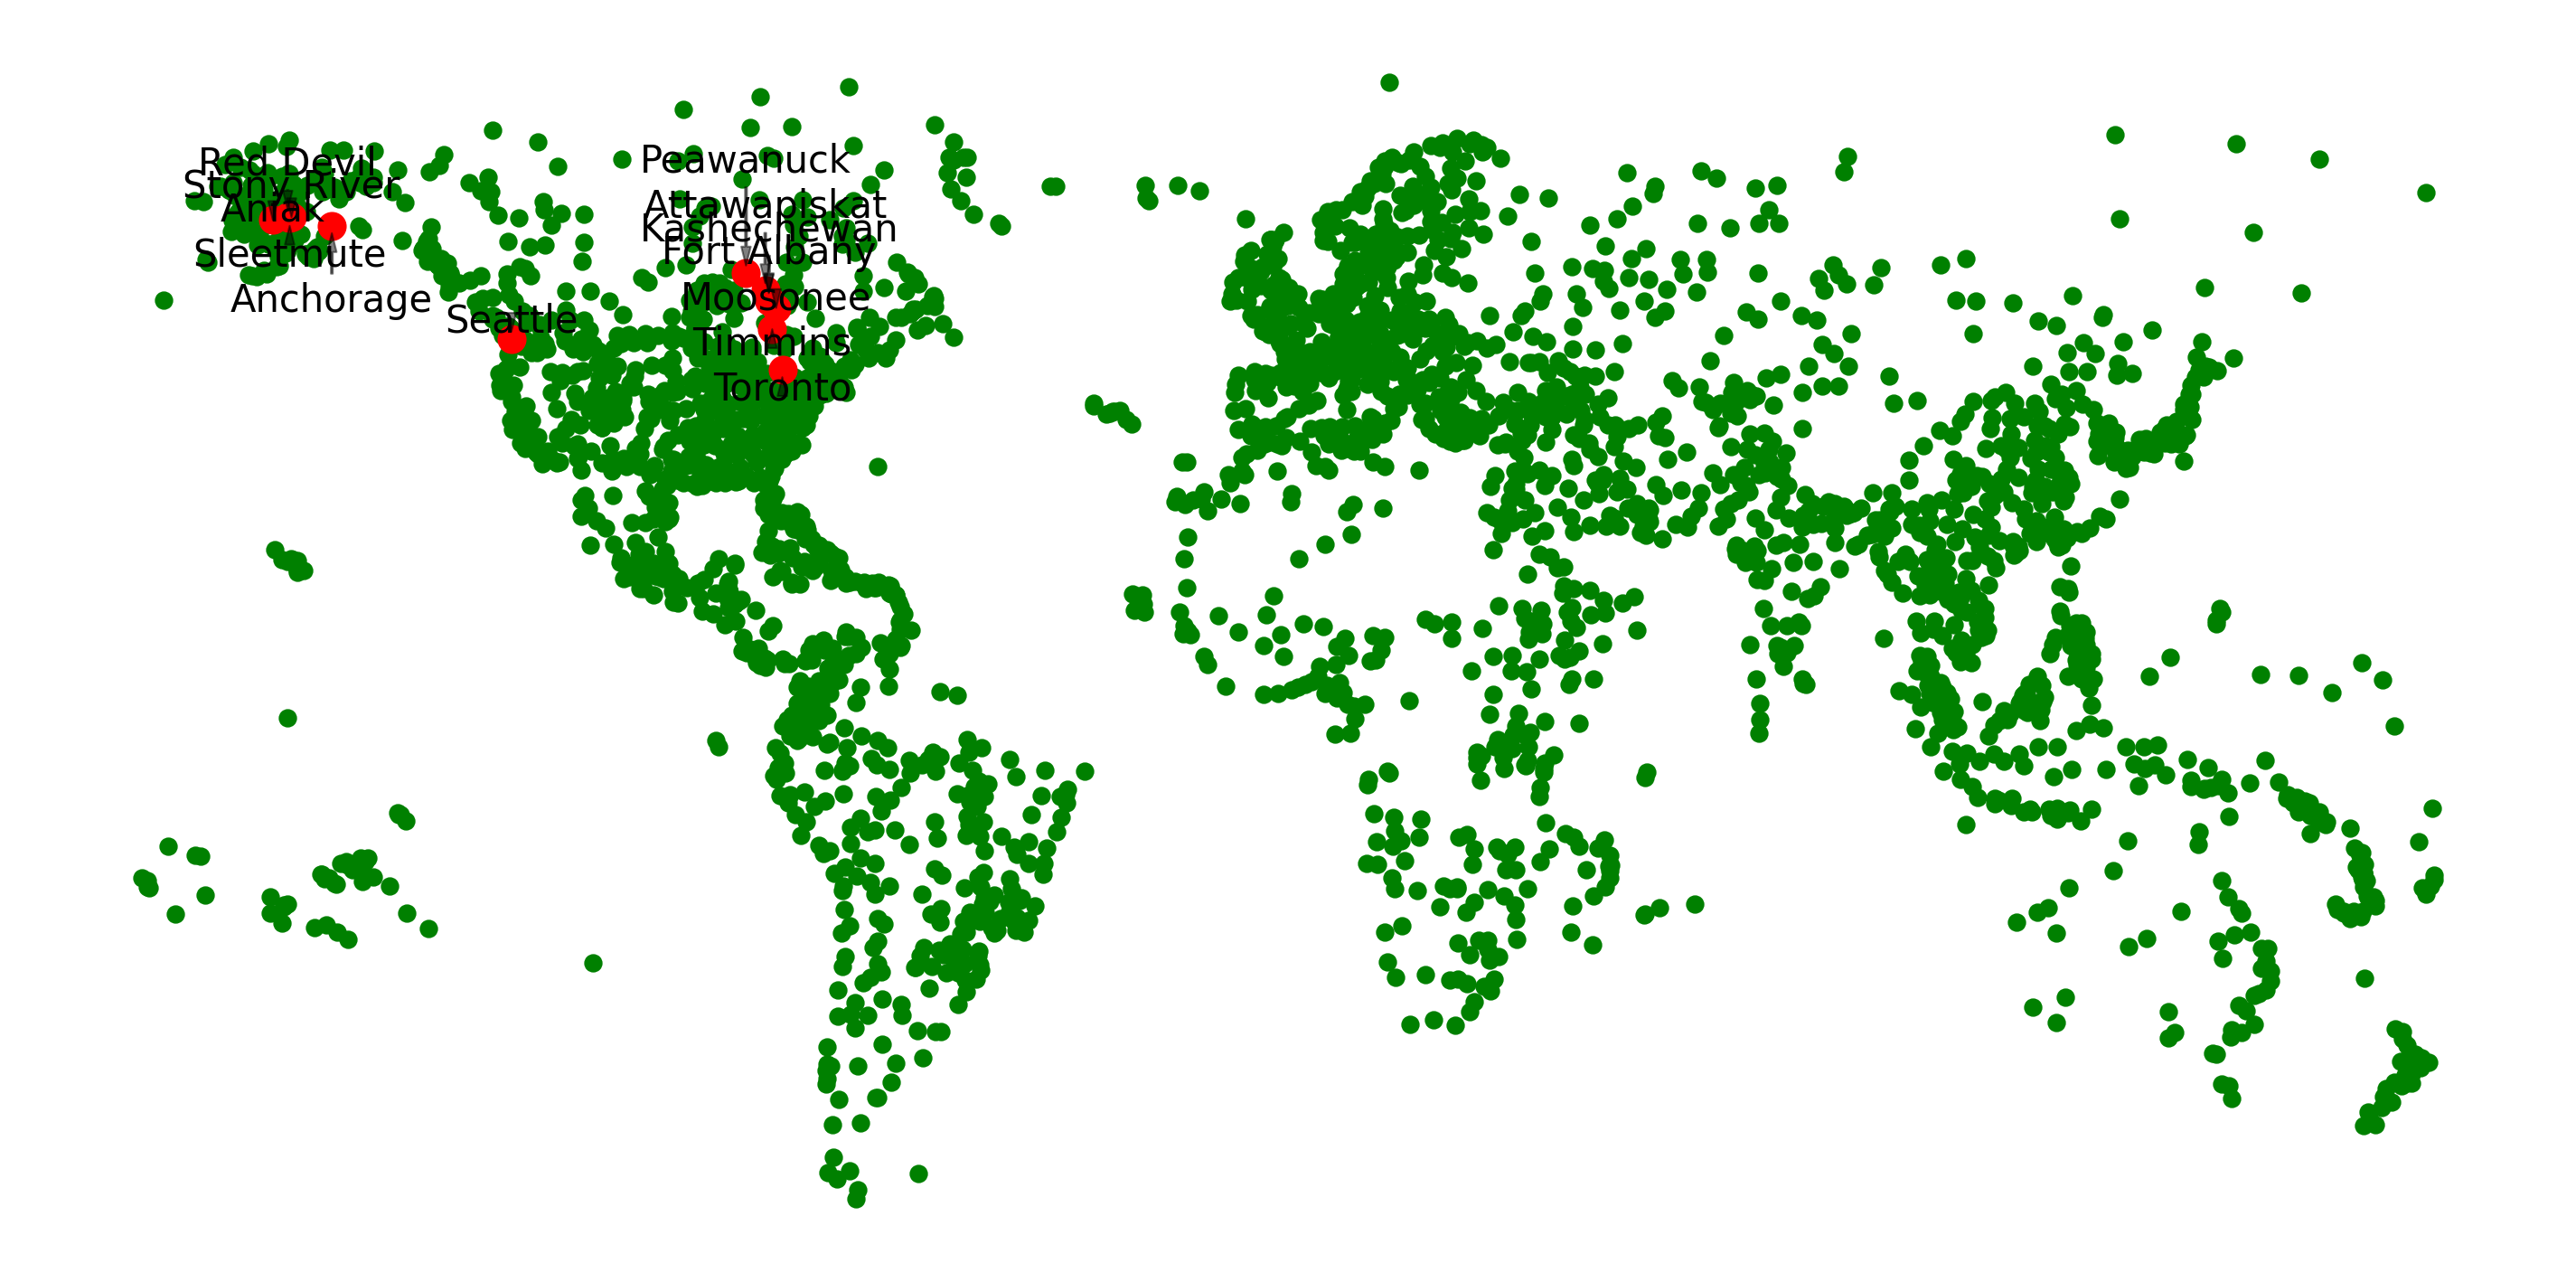

In [90]:
from adjustText import adjust_text
f, ax = plt.subplots(dpi=300,figsize=(12,6))
network1 = nx.draw(FlightsLC,pos=CityPos,with_labels=False, width=0, node_size=15, node_color='green',ax=ax)
network2 = nx.draw(FlightsLC.subgraph(longestpath),pos=CityPos,with_labels=False, width=0, node_size=45, node_color='red',ax=ax)


xdata = [CityPos[node][0] for node in longestpath]
ydata = [CityPos[node][1] for node in longestpath]
texts = []
for x, y, node in zip(xdata, ydata,longestpath):
    texts.append(plt.text(x, y, node, horizontalalignment='center', color='k'))
adjust_text(texts, add_objects=network1, autoalign='y', expand_objects=(1.05, 1.2),
            only_move={'points':'', 'text':'y', 'objects':'y'}, force_text=0.75, force_objects=0.1,
            arrowprops=dict(arrowstyle="simple, head_width=0.25, tail_width=0.05", color='k', lw=0.5, alpha=0.5))
plt.show()

d) Find average network distance among the top 100 airports by pagerank (with $alpha=0.85$)

In [91]:
pr = nx.pagerank(FlightsLC, alpha=0.85)
Top100pr=sorted(pr.values(),reverse=True)[100]
TopNodesPr=[d for d in FlightsLC if pr[d]>=Top100pr]


In [96]:
FlightsND = Flights.subgraph(TopNodesPr)
FlightsNDallpaths=dict(nx.shortest_path_length(FlightsND))

In [107]:
for city in TopNodesPr:
    averageDistance = np.mean(list(FlightsNDallpaths[city].values()))
    FlightsNDallpaths[city] = averageDistance

In [108]:
FlightsNDallpaths

{'Minneapolis': 1.683168316831683,
 'Dublin': 1.7227722772277227,
 'Athens': 1.7821782178217822,
 'Seoul': 1.504950495049505,
 'Dubai': 1.4158415841584158,
 'Lisbon': 1.7821782178217822,
 'Copenhagen': 1.6336633663366336,
 'Delhi': 1.6732673267326732,
 'Brussels': 1.5940594059405941,
 'Johannesburg': 1.7920792079207921,
 'Shanghai': 1.613861386138614,
 'Paris': 1.2178217821782178,
 'Miami': 1.5643564356435644,
 'Taipei': 1.7326732673267327,
 'Frankfurt': 1.2178217821782178,
 'Orlando': 1.6732673267326732,
 'Houston': 1.5841584158415842,
 'Doha': 1.5841584158415842,
 'New York': 1.297029702970297,
 'Fairbanks': 2.613861386138614,
 'Oslo': 1.7722772277227723,
 'Prague': 1.7326732673267327,
 'Zurich': 1.4653465346534653,
 'Chicago': 1.4653465346534653,
 'Munich': 1.4554455445544554,
 'Duesseldorf': 1.6633663366336633,
 'Denver': 1.7326732673267327,
 'Atlanta': 1.4455445544554455,
 'Charlotte': 1.702970297029703,
 'Dallas-fort Worth': 1.5841584158415842,
 'Manchester': 1.693069306930693,
 

e) Partition the network using Combo algorithm, visualize the partition 

In [21]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
def visualizePartitionShape(gdf,Y,idfield): #take geopandas dataframe gdf with zip code shapefiles and the dictionary mapping zip codes to clusters
    #visualize shapes using communities for picking colors        
    Ncolors = max(Y.values())+1
    colormap = plt.cm.tab20
    Ncolors = min(colormap.N,Ncolors)
    mapcolors = [colormap(int(x*colormap.N/Ncolors)) for x in range(Ncolors)]
    
    f, ax = plt.subplots(1,figsize=(12,7))     
    for c in range(Ncolors): #for each cluster
        if idfield=='index':
            ID=gdf.index
        else:
            ID=gdf[idfield]
        gdf.loc[ID.map(Y)==c].plot(axes=ax, color=mapcolors[c]) #visualize zip codes which belong to it using cluster color

In [160]:
import geopandas as gpd
from shapely.geometry import Point
geometry = [Point(xy) for xy in zip(cities['long. most active airport'], cities['lat. most active airport'])]
citiesgdf = gpd.GeoDataFrame(cities,geometry=geometry)

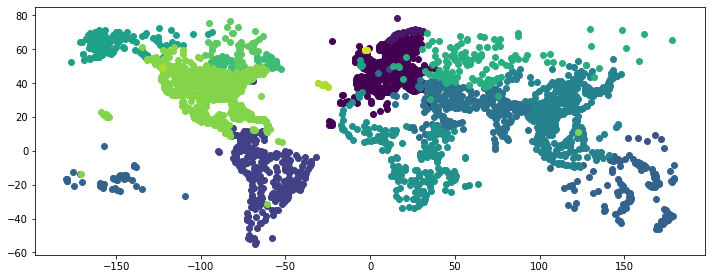

In [187]:
import warnings
warnings.filterwarnings('ignore')
PC = pycombo.execute(Flights,Inf)[0]
visualizePartitionShape(citiesgdf,PC,'index')

# Extracredit task 3. Compare weekend and weekday partitions of the taxi network

download data from: https://github.com/CUSP2020PUI/Data/raw/master/ridership.zip

## Q1. 
Aggregate provided daily taxi ridership into a) all weekend and b) all weekday ridership over the year

## Q2. 
Fit a gravity model $$ridership(o,d)\sim k\cdot pop(o) pop(d) travelime(o,d)^{-q}$$ to both networks, compare exponents (use log-scale linear regression with a slope coefficient $-q$ and intercent $\ln(k)$), replace zero ridership edges with a small number $1e-3$ for logarithm feasibility)

## Q3. 
Partition both networks using Combo algorithm, visualize and compare partitions

In [1]:
!wget https://github.com/CUSP2020PUI/Data/raw/master/ridership.zip

--2021-04-16 16:17:55--  https://github.com/CUSP2020PUI/Data/raw/master/ridership.zip
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/CUSP2020PUI/Data/master/ridership.zip [following]
--2021-04-16 16:17:55--  https://raw.githubusercontent.com/CUSP2020PUI/Data/master/ridership.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67607253 (64M) [application/zip]
Saving to: ‘ridership.zip’

ridership.zip       100%[===================>]  64.47M  7.64MB/s    in 8.1s    

2021-04-16 16:18:04 (7.94 MB/s) - ‘ridership.zip’ saved [67607253/67607253]



In [2]:
## Q1 Aggregate provided daily taxi ridership into a) all weekend and b) all weekday ridership over the year
df = pd.read_csv('ridership.zip')

In [3]:
df['dow'] = pd.to_datetime(df['Date']).dt.dayofweek
df['weekend'] = 0
del df['Date']
df.loc[df['dow']>4,'weekend']=1
df = df.groupby(['PULocationID','DOLocationID','weekend']).agg({'vehicle_count':'sum'}).reset_index()

## q2

In [4]:
pop = pd.read_csv('taxi_zone_pop.csv')
pop = pop.loc[pop.Population>0]
duration = pd.read_csv('tripduration.csv')

In [5]:

# model function

def gravity(T_i, T_j, C_ij, mob_gt):
    
    X = sm.add_constant(np.log(C_ij))
    y = np.log(mob_gt) - np.log(T_i) - np.log(T_j)
    
    model = sm.OLS(y, X).fit()
    
    return model

In [6]:
dfWeekday = df.loc[df['weekend']==0]
dfWeekend = df.loc[df['weekend']==1]

In [7]:
def population_duration(df):
    df = df.merge(pop,left_on='PULocationID',right_on='location_id')
    df = df.rename(columns={'Population':'PUPopulation'})
    df = df.merge(pop,left_on='DOLocationID',right_on='location_id')
    df = df.rename(columns={'Population':'DOPopulation'})

    df = df.merge(duration, on=['PULocationID','DOLocationID'])
    return df

In [8]:
dfWeekday = population_duration(dfWeekday)
dfWeekend = population_duration(dfWeekend)

In [42]:
model_dfWeekday = gravity(dfWeekday.PUPopulation, dfWeekday.DOPopulation, dfWeekday.duration, dfWeekday.vehicle_count)
model_dfWeekday.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.326
Model:                            OLS   Adj. R-squared:                  0.326
Method:                 Least Squares   F-statistic:                 1.183e+04
Date:                Fri, 16 Apr 2021   Prob (F-statistic):               0.00
Time:                        22:36:49   Log-Likelihood:                -47018.
No. Observations:               24432   AIC:                         9.404e+04
Df Residuals:                   24430   BIC:                         9.406e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0138      0.127     -0.109      0.913      -0.262       0.234
duration      -1.8783      0.017   -108.764      0.000      -1.912      -1.844
==============================================================================
Omnibus:                     2186.567   Durbin-Watson:                   1.238
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4457.587
Skew:                           0.592   Prob(JB):                         0.00
Kurtosis:                       4.725   Cond. No.                         89.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [41]:
model_dfWeekend = gravity(dfWeekend.PUPopulation, dfWeekend.DOPopulation, dfWeekend.duration, dfWeekend.vehicle_count)
model_dfWeekend.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.322
Model:                            OLS   Adj. R-squared:                  0.322
Method:                 Least Squares   F-statistic:                 1.158e+04
Date:                Fri, 16 Apr 2021   Prob (F-statistic):               0.00
Time:                        22:36:39   Log-Likelihood:                -46625.
No. Observations:               24426   AIC:                         9.325e+04
Df Residuals:                   24424   BIC:                         9.327e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.0561      0.125     -8.473      0.000      -1.300      -0.812
duration      -1.8297      0.017   -107.609      0.000      -1.863      -1.796
==============================================================================
Omnibus:                     2618.700   Durbin-Watson:                   1.160
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5407.187
Skew:                           0.685   Prob(JB):                         0.00
Kurtosis:                       4.854   Cond. No.                         89.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Q3. 
Partition both networks using Combo algorithm, visualize and compare partitions

In [43]:
dfWeekday['pred_trips'] = np.exp(np.log(dfWeekday['PULocationID']) + np.log(dfWeekday['DOLocationID']) + model_dfWeekday.predict(sm.add_constant(np.log(dfWeekday['duration']))))


In [24]:
x = dfWeekday[['PULocationID', 'DOLocationID', 'vehicle_count']]
G = nx.from_pandas_edgelist(x, 'PULocationID', 'DOLocationID', 'vehicle_count')
resGt = pycombo.execute(G, weight='vehicle_count')[0]

In [37]:
tz = gpd.read_file('https://data.cityofnewyork.us/api/geospatial/d3c5-ddgc?method=export&format=GeoJSON')
tz.location_id = tz.location_id.astype(int)
tz = tz.to_crs(2263)

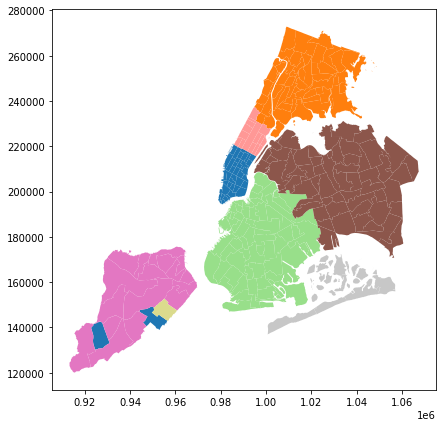

In [38]:
visualizePartitionShape(tz,resGt,'location_id')

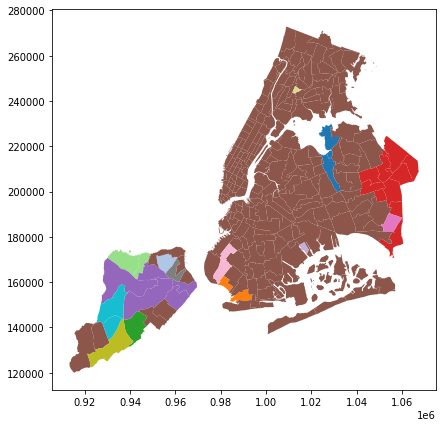

In [45]:
x = dfWeekday[['PULocationID', 'DOLocationID', 'pred_trips']]
G = nx.from_pandas_edgelist(x, 'PULocationID', 'DOLocationID', 'pred_trips')
predGt = pycombo.execute(G, weight='pred_trips')[0]
visualizePartitionShape(tz,predGt,'location_id')